In [1]:
import xskillscore
import xarray as xr
from datetime import datetime, timedelta
import h5py as h5
import pandas as pd
from modulus.metrics.general import crps
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

In [2]:
import torch
dummy = xr.open_dataset("/dvs_ro/cfs/cdirs/m1517/cascade/amahesh/hens/HENS_summer23_20230814T000000/ensemble_out_00001_2023-08-14-00-00-00.nc",
                       group='global')

In [3]:
def load_percentile_threshold(initial_time, lead_time):
    valid_time = initial_time + lead_time
    print(valid_time)
    threshold = xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_percentile95_{valid_time.month:02d}_{valid_time.hour:02d}/")
    threshold = threshold.rename({
        'VAR_2T' : 't2m',
        'latitude' : 'lat',
        'longitude' : 'lon',
    })
    return threshold['t2m'].values[:, None]

def load_observed(initial_time, lead_time, var):
    valid_time = initial_time + lead_time
    true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
    dummy = xr.open_dataset("/dvs_ro/cfs/cdirs/m1517/cascade/amahesh/hens/HENS_summer23_20230814T000000/ensemble_out_00001_2023-08-14-00-00-00.nc",
                       group='global')

    true = true.rename({'phony_dim_0' : 'time',
             'phony_dim_2' : 'lat', 
             'phony_dim_3' : 'lon',
             'phony_dim_1' : 'channel'})
    true['lat'] = dummy['lat']
    true['lon'] = dummy['lon']
    true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "d2m", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
    true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')
    return true['fields'].sel(time=valid_time, channel=var).load().values

In [4]:
def load_forecast(initial_time, lead_time_idx):
    var = 't2m'
    fin = h5.File(f"/pscratch/sd/a/amahesh/hens_h5/{var}_{initial_time:%Y%m%d}_lead-04-07-10.h5", 'r')
    pred = fin[var][0, lead_time_idx,
               ]
    return pred

In [5]:
initial_time = datetime(2023, 8, 13)
lead_time_idx = 8

In [6]:
pred = load_forecast(initial_time, lead_time_idx)

In [7]:
thresh = load_percentile_threshold(initial_time, timedelta(hours=40*6))


2023-08-23 00:00:00


In [8]:
true = load_observed(initial_time, timedelta(hours=40 * 6), var='t2m')


In [9]:
true = xr.DataArray(true,
                    dims=('lat', 'lon'),
                    coords = {'lat' : dummy['lat'],
                              'lon' : dummy['lon']})
thresh = xr.DataArray(thresh.squeeze(),
                    dims=('lat', 'lon'),
                    coords = {'lat' : dummy['lat'],
                              'lon' : dummy['lon']})

In [10]:
pred_xr = xr.DataArray(pred,
                    dims=('lat', 'ensemble', 'lon'),
                    coords = {'lat' : dummy['lat'],
                              'lon' : dummy['lon']})

In [11]:
import xarray as xr
import numpy as np

# Assuming `true` and `thresh` are your xarray DataArrays

# Find where `true` is greater than `thresh`
condition = np.logical_and(true > thresh+1.5, True)
target_lat = 32
target_lon = 360 - 92.5



In [14]:
lsm = xr.open_dataset("/global/cfs/cdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc")
lsm['LSM'].squeeze().sel(latitude=target_lat, longitude=target_lon).values

array(0.98883, dtype=float32)

In [15]:
ensemble = pred_xr.sel(lat=target_lat, lon=target_lon)
thresh = thresh.sel(lat=target_lat, lon=target_lon)

In [16]:
era5 = true.sel(lat=target_lat, lon=target_lon)

In [20]:
import matplotlib.cm as cm

viridis = cm.get_cmap('viridis')

# Get the extreme colors from the colormap
color_58_members = viridis(0)  # First color in viridis
color_7424_members = viridis(230)  # Last color in viridis


/tmp/ipykernel_65987/2092383529.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


In [21]:
medium_ens = xr.open_zarr("/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_summer2023/2023-08-13T00:00:00/ensemble.zarr")
medium_ens = medium_ens.isel(time=40).sel(lat=target_lat, lon=target_lon)['t2m'].values

In [25]:
bootstraps = []
for trial in range(2000):
    idxs = np.random.choice(7424, size=7424, replace=True)
    bootstraps.append((prediction[idxs] > thresh.values).mean())
print(np.percentile(bootstraps, 2.5), np.percentile(bootstraps,97.5))
print(np.asarray(bootstraps).mean())

0.17174030172413793 0.18938577586206898
0.18052747844827585


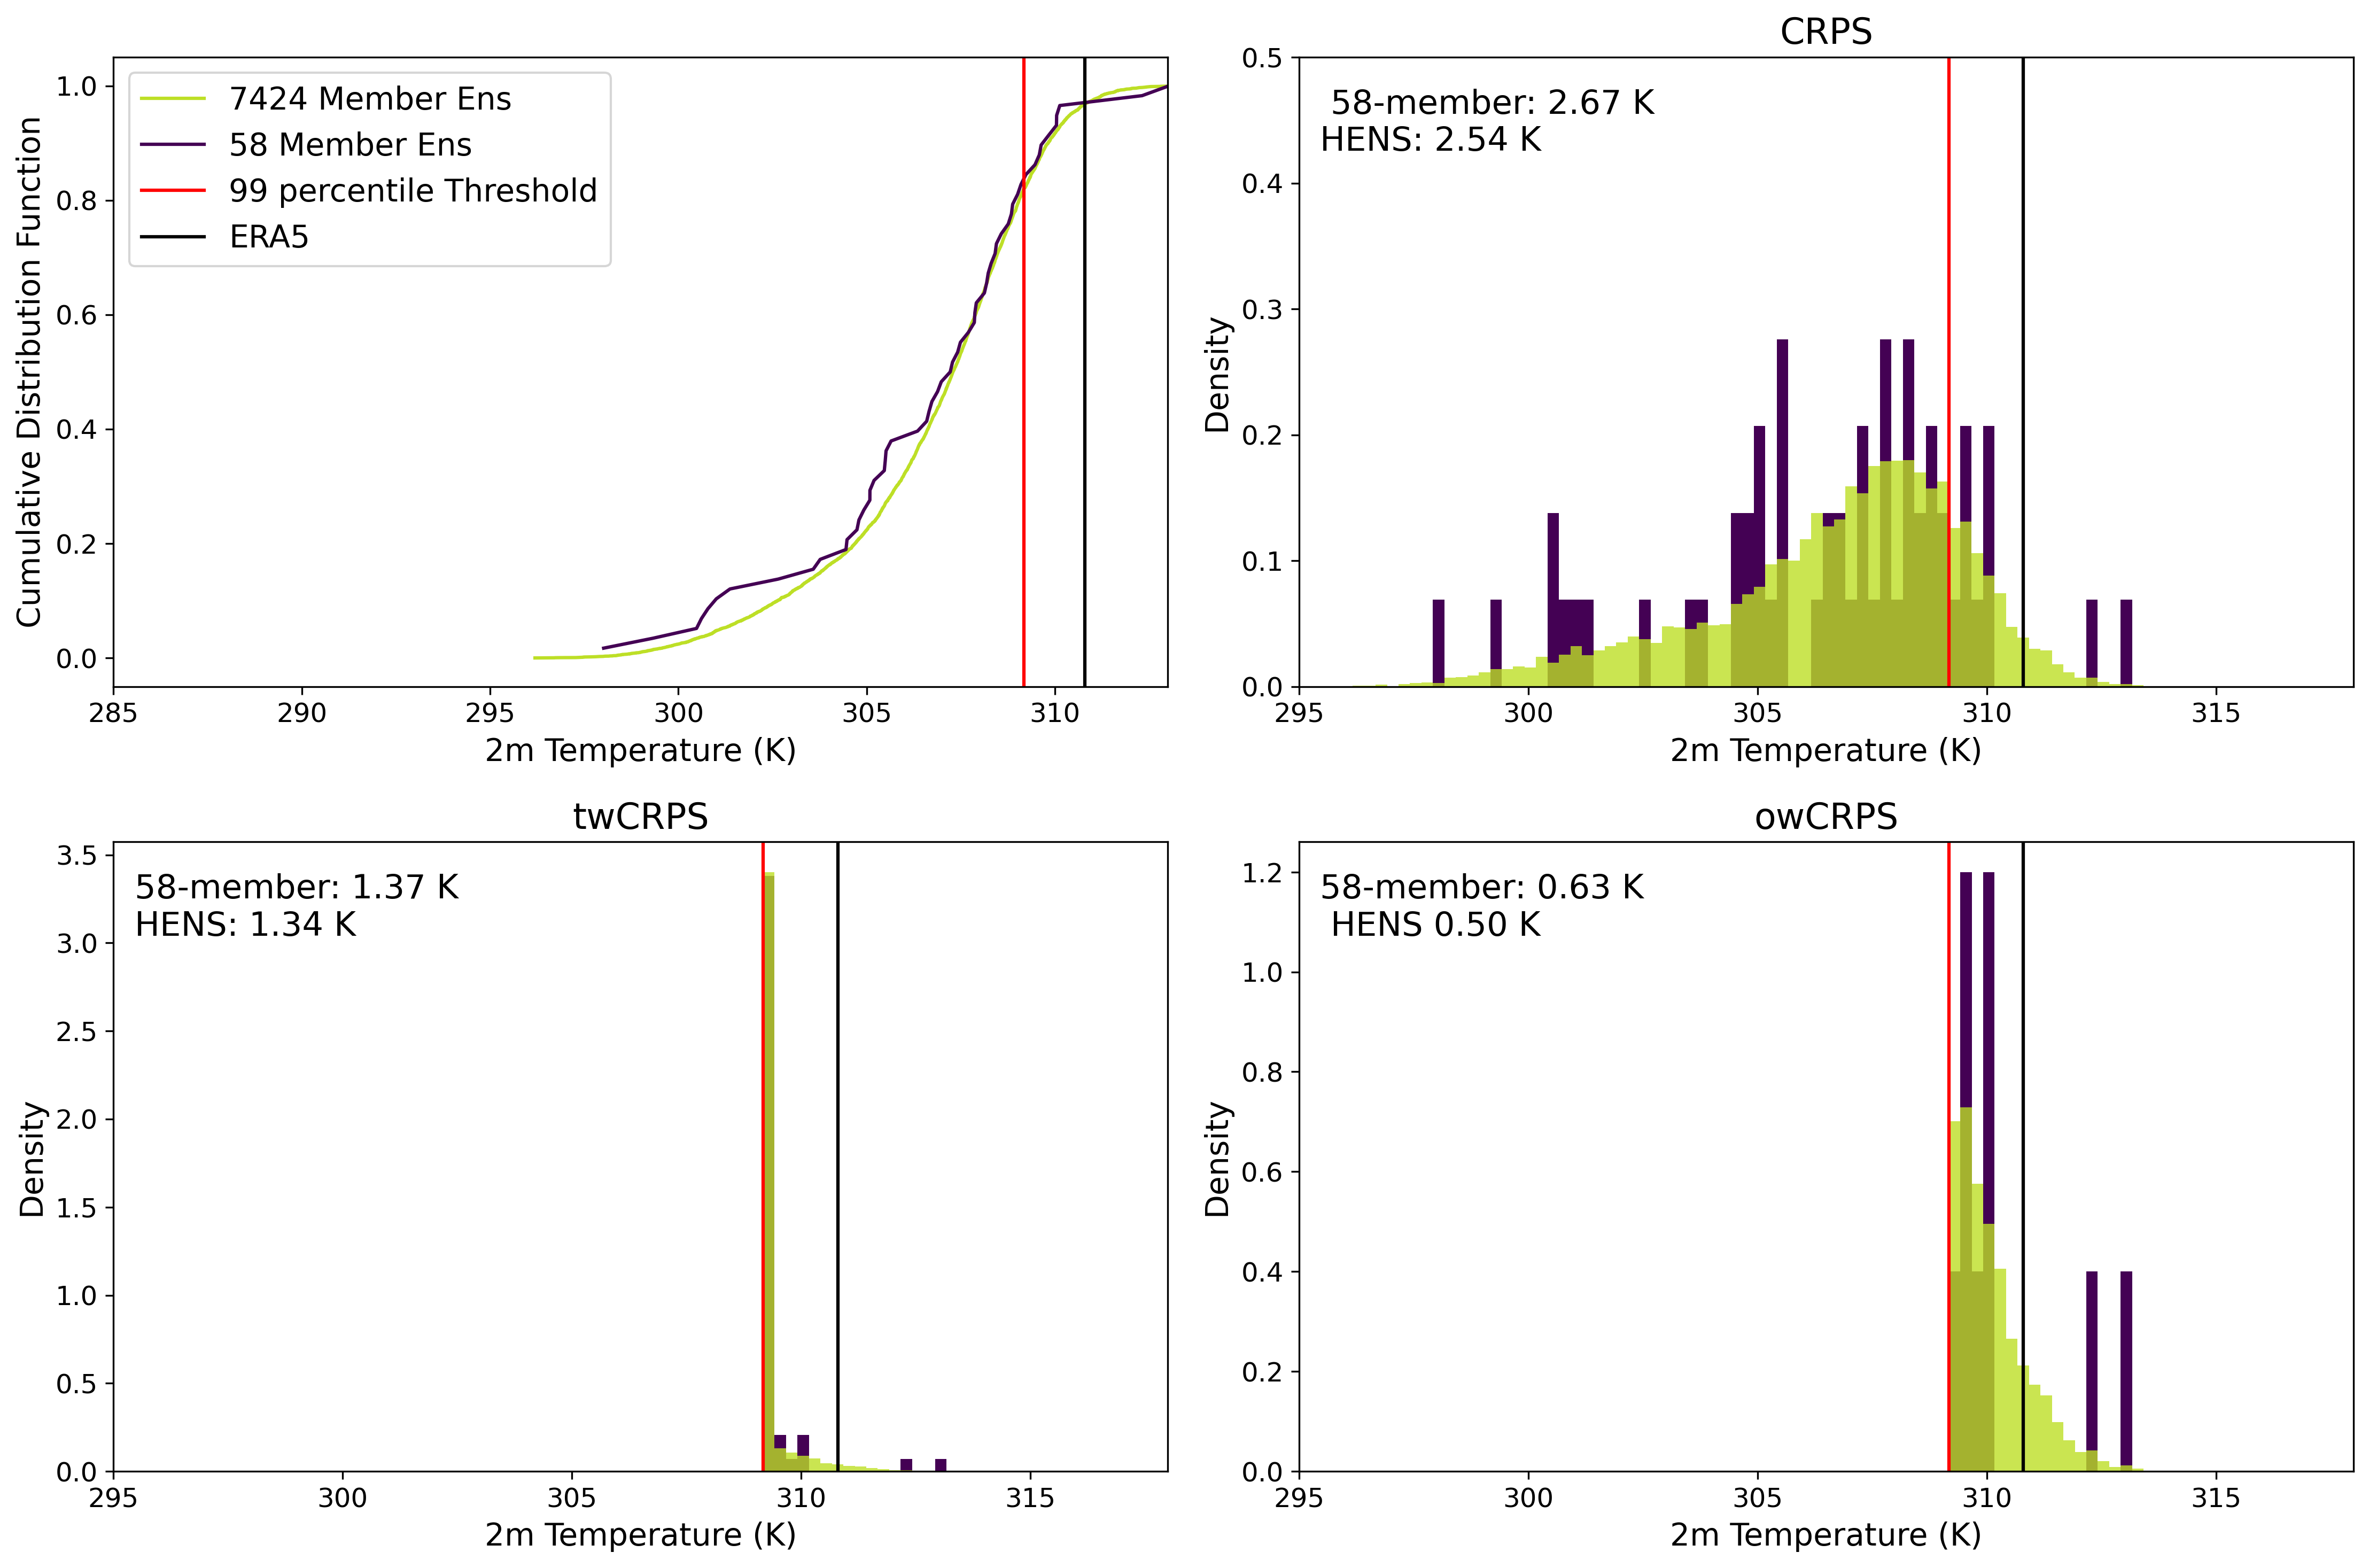

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Panel 1: CDF Comparison
np.random.seed(9999)
idxs = np.random.choice(7424, size=58)

full_sorted = np.sort(prediction)
full_cdf = np.arange(1, len(full_sorted) + 1) / len(full_sorted)

medium_sorted = np.sort(medium_ens)
medium_cdf = np.arange(1, len(medium_sorted) + 1) / len(medium_sorted)

fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
axs = axs.flatten()

axs[0].plot(full_sorted, full_cdf, linestyle='-', label='7424 Member Ens', color=color_7424_members)
axs[0].plot(medium_sorted, medium_cdf, linestyle='-', label='58 Member Ens', color=color_58_members)
axs[0].axvline(thresh, color='red', linestyle='-', label='99 percentile Threshold')
axs[0].axvline(era5, color='black', label='ERA5')
axs[0].set_ylabel("Cumulative Distribution Function")
axs[0].set_xlabel("2m Temperature (K)")
axs[0].set_xlim((285, 313))
axs[0].legend()

# Panel 3: Histogram for the entire range: CRPS
curr_medium_pred = torch.tensor(medium_ens)
curr_full_pred = torch.tensor(prediction)
curr_thresh = torch.tensor(thresh.values)

medium = np.round(crps.crps(curr_medium_pred, era5.values, method='sort'), 2)
full = np.round(crps.crps(curr_full_pred, era5.values, method='sort'), 2)

axs[1].hist(curr_medium_pred.numpy(), histtype='bar', density=True, bins=np.arange(295.17, 318, 0.25), alpha=1, label='58 member Ens', color=color_58_members)
axs[1].hist(curr_full_pred.numpy(), histtype='bar', density=True, bins=np.arange(295.17, 318, 0.25), alpha=0.8, label='7424 member Ens', color=color_7424_members)
axs[1].axvline(curr_thresh.numpy(), color='red', label='95 percentile Threshold')
axs[1].axvline(era5, color='black', label='ERA5')
axs[1].set_xlabel("2m Temperature (K)")
axs[1].set_ylabel("Density")
axs[1].set_xlim((295, 318))
axs[1].set_ylim((0, 0.5))
axs[1].text(0.02, 0.95, f" 58-member: {medium:.02f} K \nHENS: {full:.02f} K", transform=axs[1].transAxes, fontsize=15, va='top')
axs[1].set_title("CRPS")

# Panel 2: Histogram above threshold: owCRPS
curr_medium_pred = torch.tensor(medium_ens)
curr_full_pred = torch.tensor(prediction)
curr_thresh = torch.tensor(thresh.values)

curr_medium_pred = curr_medium_pred[curr_medium_pred > curr_thresh]
curr_full_pred = curr_full_pred[curr_full_pred > curr_thresh]

medium = np.round(crps.crps(curr_medium_pred, era5.values, method='sort'), 2)
full = np.round(crps.crps(curr_full_pred, era5.values, method='sort'), 2)

axs[3].hist(curr_medium_pred.numpy(), histtype='bar', density=True, bins=np.arange(curr_thresh, curr_thresh + 9.5, 0.25), alpha=1, label='58 member Ens', color=color_58_members)
axs[3].hist(curr_full_pred.numpy(), histtype='bar', density=True, bins=np.arange(curr_thresh, curr_thresh + 9.5, 0.25), alpha=0.8, label='7424 member Ens', color=color_7424_members)
axs[3].axvline(curr_thresh.numpy(), color='red', label='95 percentile Threshold')
axs[3].axvline(era5, color='black', label='ERA5')
axs[3].set_xlim((295, 318))
axs[3].set_xlabel("2m Temperature (K)")
axs[3].set_ylabel("Density")
axs[3].text(0.02, 0.95, f"58-member: {medium:.02f} K \n HENS {full:.02f} K", transform=axs[3].transAxes, fontsize=15, va='top')
axs[3].set_title("owCRPS")

# Panel 4: twCRPS
curr_medium_pred = torch.tensor(medium_ens)
curr_full_pred = torch.tensor(prediction)
curr_thresh = torch.tensor(thresh.values)

curr_medium_pred = torch.where(curr_medium_pred < curr_thresh, curr_thresh, curr_medium_pred)
curr_full_pred = torch.where(curr_full_pred < curr_thresh, curr_thresh, curr_full_pred)

medium = np.round(crps.crps(curr_medium_pred, era5.values, method='sort'), 2)
full = np.round(crps.crps(curr_full_pred, era5.values, method='sort'), 2)

axs[2].hist(curr_medium_pred.numpy(), histtype='bar', density=True, bins=np.arange(295.17, 318, 0.25), alpha=1, label='58 member Ens', color=color_58_members)
axs[2].hist(curr_full_pred.numpy(), histtype='bar', density=True, bins=np.arange(295.17, 318, 0.25), alpha=0.8, label='7424 member Ens', color=color_7424_members)
axs[2].axvline(curr_thresh.numpy(), color='red',  label='95 percentile Threshold')
axs[2].axvline(era5, color='black', label='ERA5')
axs[2].set_xlabel("2m Temperature (K)")
axs[2].set_ylabel("Density")
axs[2].set_xlim((295, 318))
axs[2].text(0.02, 0.95, f"58-member: {medium:.02f} K \nHENS: {full:.02f} K", transform=axs[2].transAxes, fontsize=15, va='top')
axs[2].set_title("twCRPS")

plt.tight_layout()
plt.savefig("crps_demo.pdf")
plt.show()


In [51]:
prediction.min()

296.19327